I found Im-balance class of target by EDA .

So I tried re-balance impact study.

Special thanks for "SMOTE" or not to "SMOTE" ... dealing with imbalanced dataset ...!!  by Mr.Remek Kinas

[https://www.kaggle.com/c/tabular-playground-series-may-2021/discussion/235795](http://)

[https://www.kaggle.com/remekkinas/tps-5-weighted-training-xgb-rf-lr-smote](http://)

Don't forget to vote !!

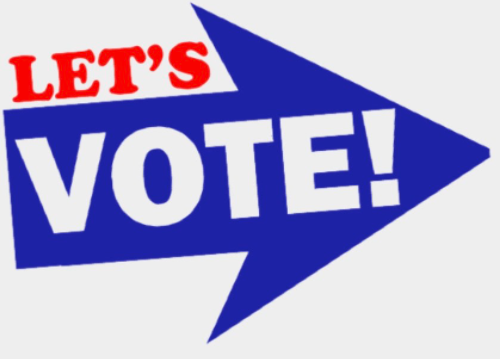

Frist , SMOTE  image is here .
SMOTE（Synthetic Minority Over-sampling Technique）

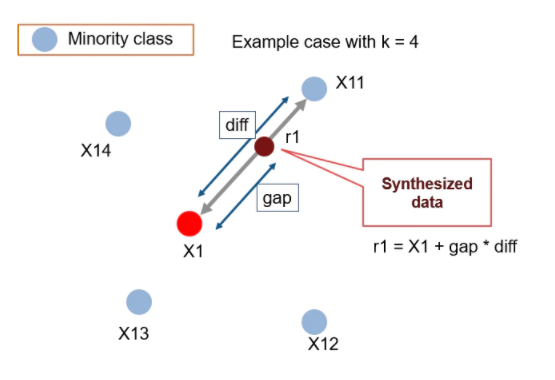


Addtional more Advanced is ADASYN


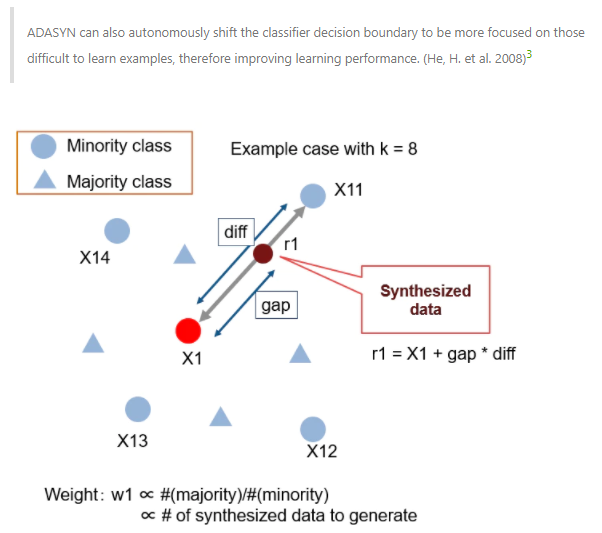

My strategy is  below.

①　Optimazed LGBM,Then FIX parameter and feature eng.

[https://www.kaggle.com/hayahiko/tps-may-easy-way-lgbm-optuna-step-by-step]

②  + Oversample code = SMOTE

③  + Oversampel code = ADSYN

In[21]  oversample = SMOTE()  or ADASYN() , Only switch!! another is same code. 

Digest result

①　PB SCORE is 1.08644

②　OOF All_logloss 0.953626756433771    / PB  1.33807

③　OOF All_logloss 0.9713155172916581   /  PB    1.31422

too over-fit (-_-)

I am studying now. If do you have more good study , please share me.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# Reading files from directory
import os
import pickle
 
# Data manipulation & analysis
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows', 500)
import datetime as dt
 
import numpy as np
import scipy

# Visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
 
 # 実行に関係ない警告を無視
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import gc
import json
import math

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score,roc_auc_score,log_loss
from sklearn.metrics import mean_squared_error, mean_squared_log_error


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

from lightgbm import LGBMClassifier
import lightgbm


In [ ]:
#実行環境がどこの階層にあるか、パスを検索
import os
print(os.getcwd())

In [ ]:
train = pd.read_csv("../input/tabular-playground-series-may-2021/train.csv")
test = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-may-2021/sample_submission.csv")

In [ ]:
display(train.head())
display(train.describe())
display(train.info())

In [ ]:
display(test.head())
display(test.describe())
display(test.info())

In [ ]:
train.columns

In [ ]:
#--------------------------------
#数値の特徴量　※上級者は、特徴量のリストを作成している。
#------------------------------
features_num = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', ]
features_cat = ['target'] 

In [ ]:
# Categorical features distribution 

# Params
n_col = 1
n_row = round(len(features_num) )
size = (n_col * 10, n_row * 4.5)

#Create figure
plt.subplots(n_row,n_col,figsize=size)

# enumerate関数　for - loop コードの代用 
for  i ,feature  in enumerate(features_num , 1):
    plt.subplot(n_row, n_col , i)
    sns.countplot(x = feature, hue = 'target', data = train)
    plt.xlabel(feature, fontsize=9); plt.legend()
plt.show()


train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

label_dict = {val:idx for idx, val in enumerate(train['target'].unique())}
train['target_num'] = train['target'].map(label_dict)

feat_cols = train.drop(["target", "target_num"], axis=1).columns
train_unique_list= []
test_nunique_list = []

for col in feat_cols:
    train_unique_list.append(train[col].nunique())
    test_nunique_list.append(test[col].nunique())

unique_df = pd.DataFrame(data=train_unique_list, index=feat_cols, columns=["train_nunique"])
unique_df["test_nunique"] = test_nunique_list

unique_df.style.background_gradient(cmap="Blues")

from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["variables"] = feat_cols
vif["VIF_train"] = [variance_inflation_factor(train[feat_cols].values, i)\
                    for i in range(train[feat_cols].shape[1])]
vif["VIF_test"] = [variance_inflation_factor(test[feat_cols].values, i)\
                   for i in range(test[feat_cols].shape[1])]

#vif.style.background_gradient(cmap="cool")


#vifをグラフ化する
plt.plot(vif["VIF_test"])
plt.plot(vif["VIF_train"])

Both train and test is similar to variance_inflation_factor.

In [ ]:
train

In [ ]:
##--------------------------------------------
#カテゴリfeature  　ラベルエンコーダー
#---------------------------------------------
for feature in features_cat :
    le = LabelEncoder()
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])

In [ ]:
# 学習データを特徴量と目的変数に分ける  正解ラべルを記入
#train_x = train.drop(["target", "target_num"], axis=1)
train_x = train.drop(["target"], axis=1)
train_y = train['target']

In [ ]:
# 変数Idを除外する
train_x = train_x.drop(['id'], axis=1)
test_x = test.drop(['id'], axis=1)

In [ ]:
from imblearn.over_sampling import KMeansSMOTE
from sklearn.cluster import MiniBatchKMeans
for label, count in zip(*np.unique(train_y, return_counts=True)):
    print('Class {} has {} samples'.format(label, count))

kmeans_smote = KMeansSMOTE(
    sampling_strategy = 'not majority',
    random_state = 42,
    k_neighbors = 10,
    cluster_balance_threshold = 0.1,
    kmeans_estimator = MiniBatchKMeans(n_clusters=100, random_state=42)
    #kmeans_estimator = 100
)
train_xS, train_yS = kmeans_smote.fit_resample(train_x, train_y)

for label, count in zip(*np.unique(train_yS, return_counts=True)):
    print('Class {} has {} samples after oversampling'.format(label, count))

##--------------------------------------------
#カテゴリfeature  スケーラー
#---------------------------------------------
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test)

In [ ]:
train_xS = pd.DataFrame(train_xS, columns=features_num , index=None)
train_xS

In [ ]:
train_x = pd.DataFrame(train_xS ) 
test_x = pd.DataFrame(test_x ) 
train_x

#!pip install imbalanced-learn
import imblearn
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
 
undersample =  ClusterCentroids(random_state=0) # RandomUnderSampler(random_state=0)
train_xS, train_yS = undersample.fit_resample(train_x, train_y)
np.sum(train_yS, axis = 0)



In [ ]:
#import imblearn
#from imblearn.over_sampling import SMOTE ,ADASYN

#oversample = SMOTE() #ADASYN()
#train_xS, train_yS = oversample.fit_resample(train_x, train_y)
#np.sum(train_yS, axis = 0)

In [ ]:
test_x

SMOTE（Synthetic Minority Over-sampling Technique）使ってみてどうか
[https://imbalanced-learn.org/stable/over_sampling.html](http://)

In [ ]:
##############################
#######     LGBMClassifier by tunner
################################

train_oof_smote_0 = np.zeros((len(train_xS), 4))
temp_test = np.zeros((len(test_x), 4))


#lgbm_params = study.best_trial.params
lgbm_params = {'reg_alpha': 13.777202060313781,
               'reg_lambda': 0.010176661007259611,
               'num_leaves': 109, 'learning_rate': 0.2,               
               'max_depth': 3,
               'n_estimators': 48126, 
               'min_child_samples': 27,
               'min_child_weight': 0.22183890336004472,
               'subsample': 0.4315725341793898, 
               'colsample_bytree': 0.1}


NUM_FOLDS = 10
kf =  StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=137)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(train_xS, train_yS))):
        print(f'Fold {f+1}')
        train_df = train_xS.iloc[train_ind].reset_index(drop=True)
        val_df = train_xS.iloc[val_ind].reset_index(drop=True)
        train_target = train_yS.iloc[train_ind].reset_index(drop=True)
        val_target = train_yS.iloc[val_ind].reset_index(drop=True)

        model = LGBMClassifier(**lgbm_params)
        model =  model.fit(train_df, train_target,eval_set=[(val_df,val_target)],early_stopping_rounds=100,verbose=False)
        
        temp_oof = model.predict_proba(val_df)
        print(log_loss(val_target, temp_oof))
        train_oof_smote_0[val_ind] = temp_oof

        temp_test += model.predict_proba(test_x)
        test_preds_smote_0 = temp_test/NUM_FOLDS

        
print('All_logloss',log_loss(train_yS, train_oof_smote_0))
np.save('train_oof_smote_0', train_oof_smote_0 ) #for validation
np.save('test_preds_smote_0',test_preds_smote_0 ) #for submission

In [ ]:
# importanceを表示する
plt.rcParams["figure.figsize"] = (10, 5)
lightgbm.plot_importance(model,max_num_features = 25,height=.8)

In [ ]:
##### 提出用ファイルの作成 ヘッダー無設の設定

#test = pd.read_csv("../input/tabular-playground-series-may-2021/test.csv")

submission = pd.DataFrame( test_preds_smote_0)
submission.columns = ['Class_1', 'Class_2', 'Class_3', 'Class_4']
submission['id'] = test['id']
submission = submission[['id', 'Class_1', 'Class_2', 'Class_3', 'Class_4']]

submission.to_csv("submission_smote_0.csv", index=False)
display(submission.head(), submission.tail())